# Google's Word2Vec CNN + Bi-directional RNN + Bi-directional LSTM Network

Importing all the required libraries along with some instance variables initialization.

It is important to note that **INPUT_SIZE** plays a big role in the model convergence.  
The value should be the average number of words per review.  
This shall yield the most optimum model state for faster convergence across the network.

**EPOCHS** is set to `10` only to select the best model with the best hyper-parameters configuration for the fastest network convergence.

Experimented with **Hinge** loss to further penalizes the predictions when they are incorrect and also when they are not confident. The penalization rate is lower as the prediction probability is more accurate. The implementation of this loss function is to minimize overfitting by penalizing.  
However, the loss in accuracy are very large. The resultant accuracy was around (64%) due to the penalizing impact of the Hinge loss function.  Due to the high percentage loss in accuracy, the **Categorical Crossentropy** is used as usual.  The confidence of the prediction will be based on the collective voting of all the model's outcome.  

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from keras.backend.tensorflow_backend import set_session
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.python.keras.layers import Dense, Embedding, Dropout, Flatten, Input
from tensorflow.python.keras.layers import LSTM, Bidirectional, SimpleRNN, Conv1D, MaxPool1D
from keras.engine.topology import Layer, InputSpec
from tensorflow.python.keras import initializers, regularizers, constraints
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.preprocessing import text as keras_text, sequence as keras_seq
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
from sklearn.utils import shuffle
from tensorflow import set_random_seed
import gc
import os

#myrand=np.random.randint(1, 99999 + 1)
myrand=58584
np.random.seed(myrand)
set_random_seed(myrand)
z=0

EMBEDDING_SIZE=300
WORDS_SIZE=8000
INPUT_SIZE=100
NUM_CLASSES=2
EPOCHS=10

# To allow dynamic GPU memory allowcation for model training
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  
config.log_device_placement = True

sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


Importing all the data from:
 * eRezeki
 * IMDB
 * Amazon
 * Yelp


In [2]:
mydata = pd.read_csv('../../../../../Master (Sentiment Analysis)/Paper/Paper 3/Datasets/eRezeki/eRezeki_(text_class)_unclean.csv',header=0,encoding='utf-8')
mydata = mydata.loc[mydata['sentiment'] != "neutral"]
mydata['sentiment'] = mydata['sentiment'].map({'negative': 0, 'positive': 1})

mydata1 = pd.read_csv('../../../../../Master (Sentiment Analysis)/Paper/Paper 3/Datasets/IMDB/all_random.csv',header=0,encoding='utf-8')
mydata = mydata.append(mydata1)
mydata = shuffle(mydata)

mydata1 = pd.read_csv('../../../../../Master (Sentiment Analysis)/Paper/Paper 3/Datasets/Amazon(sports_outdoors)/Amazon_UCSD.csv',header=0,encoding='utf-8')
mydata1['feedback'] = mydata1['feedback'].astype(str)
mydata = mydata.append(mydata1)
mydata = shuffle(mydata)

mydata1 = pd.read_csv('../../../../../Master (Sentiment Analysis)/Paper/Paper 3/Datasets/Yelp(zhang_paper)/yelp_zhang.csv',header=0,encoding='utf-8')
mydata1['feedback'] = mydata1['feedback'].astype(str)
mydata = mydata.append(mydata1)

del(mydata1)
gc.collect()

mydata = shuffle(mydata)
mydata = shuffle(mydata)
mydata = shuffle(mydata)

Spllitting the data into training (70%) and testing (30%) sets.

In [3]:
x_train, x_test, y_train, y_test = train_test_split(mydata.iloc[:,0], mydata.iloc[:,1],
                                                    test_size=0.3, 
                                                    random_state=myrand, 
                                                    shuffle=True)
old_y_test = y_test

Prepare tokenizer

In [4]:
## Create tokkenizer from full list of texts
tokenizer = keras_text.Tokenizer(char_level=False)
tokenizer.fit_on_texts(list(mydata['feedback']))
tokenizer.num_words=WORDS_SIZE

Create sequence file from the tokkenizer for training and testing sets.

In [5]:
## Tokkenizing train data and create matrix
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = keras_seq.pad_sequences(list_tokenized_train, 
                                  maxlen=INPUT_SIZE,
                                  padding='post')
x_train = x_train.astype(np.int64)

## Tokkenizing test data and create matrix
list_tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = keras_seq.pad_sequences(list_tokenized_test, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_test = x_test.astype(np.int64)

Perform One Hot Encoding (OHE) to the labes of training and testing sets.

In [6]:
y_train = to_categorical(y_train, num_classes=NUM_CLASSES).astype(np.int64)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES).astype(np.int64)

Prepare **Word2Vec CNN + Bi-RNN + Bi-LSTM** embeddings layer

In [7]:
word2vec = KeyedVectors.load_word2vec_format('../../../../../Master (Sentiment Analysis)/Paper/Paper 3/Datasets/googlew2v/GoogleNews-vectors-negative300.bin', binary=True)
word_index = tokenizer.word_index

vocabulary_size=min(len(word_index)+1,8000)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_SIZE))
for word, i in word_index.items():
    if i>=WORDS_SIZE:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_SIZE)

embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=INPUT_SIZE,
                            trainable=False)

Define and build the **Word2Vec CNN + Bi-RNN + Bi-LSTM** model

In [8]:
model = Sequential(name='Word2Vec CNN + Bi-RNN + Bi-LSTM')

model.add(embedding_layer)
model.add(Conv1D(filters=250, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3))
model.add(Conv1D(filters=250, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3))
model.add(Bidirectional(LSTM(250,return_sequences=True,  activation='relu')))
model.add(Bidirectional(SimpleRNN(250)))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(2, activation='softmax'))

## Define multiple optional optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.0, amsgrad=False)

## Compile model with metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Word2Vec CNN + Bi-RNN + Bi-LSTM model built: ")
model.summary()

Word2Vec CNN + Bi-RNN + Bi-LSTM model built: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          2400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 250)          225250    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 33, 250)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 33, 250)           125250    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 250)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 11, 500)           1002000   
_________________________________________________________________
bidirectional_1 (Bidirection (

Create **TensorBoard callbacks** for:
 * Historical data
 * Training and evaluation gain/loss
 
Also, create the **best-model callback** to save the **best** model every epoch.

In [9]:
## Create TensorBoard callbacks

callbackdir= '/project/ten'

tbCallback = TensorBoard(log_dir=callbackdir, 
                         histogram_freq=0, 
                         batch_size=128,
                         write_graph=True, 
                         write_grads=True, 
                         write_images=True)

tbCallback.set_model(model)

mld = '/project/model/word2vec_cnn_birnn_bilstm.hdf5_%s'%(z)

## Create best model callback
mcp = ModelCheckpoint(filepath=mld, monitor="val_acc",
                      save_best_only=True, mode='max', period=1, verbose=1)

**Train** the model

In [10]:
print('Training the Word2Vec CNN + Bi-RNN + Bi-LSTM model')
history = model.fit(x = x_train,
          y = y_train,
          validation_data = (x_test, y_test),
          epochs = EPOCHS,
          batch_size = 128,
          verbose =2,
          callbacks=[mcp,tbCallback])

Training the Word2Vec CNN + Bi-RNN + Bi-LSTM model
Train on 663700 samples, validate on 284443 samples
Epoch 1/10
 - 196s - loss: 0.2482 - acc: 0.8960 - val_loss: 0.2101 - val_acc: 0.9144

Epoch 00001: val_acc improved from -inf to 0.91439, saving model to /project/model/word2vec_cnn_birnn_bilstm.hdf5_0
Epoch 2/10
 - 195s - loss: 0.1982 - acc: 0.9202 - val_loss: 0.1950 - val_acc: 0.9225

Epoch 00002: val_acc improved from 0.91439 to 0.92249, saving model to /project/model/word2vec_cnn_birnn_bilstm.hdf5_0
Epoch 3/10
 - 196s - loss: 0.1938 - acc: 0.9217 - val_loss: 0.2519 - val_acc: 0.8953

Epoch 00003: val_acc did not improve from 0.92249
Epoch 4/10
 - 195s - loss: 0.1934 - acc: 0.9222 - val_loss: 0.1900 - val_acc: 0.9233

Epoch 00004: val_acc improved from 0.92249 to 0.92332, saving model to /project/model/word2vec_cnn_birnn_bilstm.hdf5_0
Epoch 5/10
 - 195s - loss: 0.1689 - acc: 0.9330 - val_loss: 0.2168 - val_acc: 0.9131

Epoch 00005: val_acc did not improve from 0.92332
Epoch 6/10
 -

**Predict** the testing set using the best model from the run.

In [11]:
print('\nPredicting the model')
model = load_model(mld)
results = model.evaluate(x_test, y_test, batch_size=128)
for num in range(0,2):
    print(model.metrics_names[num]+': '+str(results[num]))


Predicting the model
284443/284443 [==============================] - 28s 97us/step
loss: 0.188485972190364
acc: 0.9258726704471546


**Evaluate** the performance of the model on the testing set using:
 * Confusion matrix
 * Accuracy
 * Precision
 * Recall
 * F-Measure

In [12]:
print('\nConfusion Matrix')
predicted = model.predict_classes(x_test)
confusion = confusion_matrix(y_true=old_y_test, y_pred=predicted)
print(confusion)

## Performance measure
print('\nWeighted Accuracy: '+ str(accuracy_score(y_true=old_y_test, y_pred=predicted)))
print('Weighted precision: '+ str(precision_score(y_true=old_y_test, y_pred=predicted, average='weighted')))
print('Weighted recall: '+ str(recall_score(y_true=old_y_test, y_pred=predicted, average='weighted')))
print('Weighted f-measure: '+ str(f1_score(y_true=old_y_test, y_pred=predicted, average='weighted')))



Confusion Matrix
[[ 98128  12010]
 [  9075 165230]]

Weighted Accuracy: 0.9258726704471546
Weighted precision: 0.9256983795327447
Weighted recall: 0.9258726704471546
Weighted f-measure: 0.9256815974399454


**Plot** the model training history for training and evaluation sets.

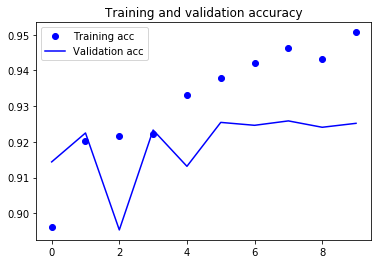

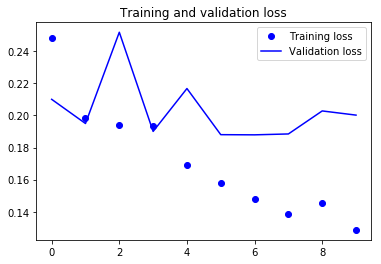

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()